<a href="https://colab.research.google.com/github/ProValarous/Reinforcement-Learning-Labs/blob/main/Rec_module_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recitation Module #2: Dynammic Programming & Monte Carlo Methods

Topics covered:
- Value Iteration
- Policy Interation
- Monte-Carlo Prediction


## Importing Libraries and Dependencies


In [ ]:
# HIDE OUTPUT
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

In [ ]:
# HIDE OUTPUT
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!sudo apt-get install xvfb
!pip install xvfbwrapper
!pip install gymnasium

In [1]:
%matplotlib inline
import gym
import gymnasium as gym
import numpy as np
from gym.wrappers.record_video import RecordVideo
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from matplotlib import pyplot as plt

/home/nightwing/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
## Some Display Utility functions

display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""


def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data=''''''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")


def wrap_env(env):
    env = RecordVideo(env, './video')
    return env


### Techniques for solving MDPs can be separated into three categories:

1. **Value-based techniques:** aim to learn the value of states (or learn an estimate for value of states) and
actions: that is, they learn value functions or Q functions. We then use policy extraction to get a
policy for deciding actions.
2. **Policy-based techniques:** learn a policy directly, which completely by-passes learning values of states
or actions all together. This is important if for example, the state space or the action space are massive
or infinite. If the action space is infinite, then using policy extraction as defined in Part I is not
possible because we must iterate over all actions to find the optimal one. If we learn the policy
directly, we do not need this.
3. **Hybrid techniques:** that combine value- and policy-based techniques

## Value Iteration

Value Iteration is a dynamic-programming method for finding the optimal value function $V^*$ by solving the
Bellman equations iteratively. It uses the concept of dynamic programming to maintain a value function $V^*$
that approximates the optimal value function $V^*$ , iteratively improving $V$ until it converges to $V^*$ (or
close to it).



**The algorithm is as follows:**

**Input:** MDP $M = \langle S, s_0, A, P_a(s' \mid s), r(s, a, s') \rangle$  
**Output:** Value function $V$  

Set $V$ to arbitrary value function; e.g., $V(s) = 0$ for all $s$  

---

**Repeat**  
- $\Delta \gets 0$  
- **For each** $s \in S$  
  - $V'(s) \gets \max_{a \in A(s)} \sum_{s' \in S} P_a(s' \mid s) \left[ r(s, a, s') + \gamma V(s') \right]$ ← _Bellman equation_  
  - $\Delta \gets \max(\Delta, |V'(s) - V(s)|)$  
- $V \gets V'$  

**Until** $\Delta \leq \theta$  

---



We could also write the algorithm using the idea of Q-values, which is closer to a code-based
implementation:

<img src="https://lcalem.github.io/imgs/sutton/value_iteration.png" alt="Value Iteration" width="700" height="300">


In [3]:
def value_iteration(env, gamma = 1.0):

    # initialize value table with zeros
    value_table = np.zeros(env.observation_space.n)

    # set number of iterations and threshold
    no_of_iterations = 100000
    threshold = 1e-20

    for i in range(no_of_iterations):

        # On each iteration, copy the value table to the updated_value_table
        updated_value_table = np.copy(value_table)

        # Now we calculate Q Value for each actions in the state
        # and update the value of a state with maximum Q value

        for state in range(env.observation_space.n):
            Q_value = []
            for action in range(env.action_space.n):
                next_states_rewards = []

                # (TODO) implement bellman equation for the value function
                # for next_state_reward in env.P[state][action]:
                for prob, next_state, reward, done in env.P[state][action]:
                    next_states_rewards.append(prob * (reward + gamma * value_table[next_state] * (not done)))
                
                Q_value.append(sum(next_states_rewards))

            updated_value_table[state] = max(Q_value)

        # we will check whether we have reached the convergence i.e whether the difference
        # between our value table and updated value table is very small. But how do we know it is very
        # small? We set some threshold and then we will see if the difference is less
        # than our threshold, if it is less, we break the loop and return the value function as optimal
        # value function

        # (TODO) implement convergence check
        error = np.sum(np.fabs(updated_value_table - value_table))
        value_table = updated_value_table.copy()

        if error < threshold:
            print("Converged at iteration: {}".format(i))
            break


    return value_table

In [4]:
def extract_policy(env, value_table, gamma = 1.0):
    # initialize the policy with zeros
    policy = np.zeros(env.observation_space.n)

    for state in range(env.observation_space.n):

        # (TODO) initialize the Q table for a state
        Q_table = np.zeros(env.action_space.n)

        # (TODO) compute Q value for all ations in the state
        for action in range(env.action_space.n):
            # for next_sr in env.P[state][action]:
            for prob, next_state, reward, done in env.P[state][action]:
                Q_table[action] += prob * (reward + gamma * value_table[next_state] * (not done))
                

        # (TODO) select the action which has maximum Q value as an optimal action of the state
        policy[state] = np.argmax(Q_table)

    return policy

In [5]:
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

In [6]:
env_train = gym.make('FrozenLake-v1',desc=generate_random_map(size=8),render_mode="rgb_array")
venv_train = env_train.unwrapped

In [7]:
optimal_value_function = value_iteration(env=venv_train,gamma=0.5)
# optimal_value_function = value_iteration(env=env_train,gamma=0.5)

Converged at iteration: 64


In [8]:
optimal_policy = extract_policy(venv_train,optimal_value_function, gamma=0.9)
# optimal_policy = extract_policy(env_train,optimal_value_function, gamma=0.9)

In [9]:
print(optimal_policy)

[1. 2. 3. 2. 2. 2. 0. 0. 1. 0. 0. 2. 2. 1. 0. 3. 1. 1. 1. 2. 2. 3. 0. 0.
 3. 2. 2. 3. 0. 0. 2. 1. 0. 2. 0. 0. 2. 1. 3. 2. 1. 1. 1. 1. 2. 0. 0. 2.
 3. 3. 0. 0. 0. 0. 0. 2. 0. 0. 2. 1. 1. 1. 1. 0.]


In [ ]:
# Create an environment (e.g., CartPole)
total_reward = 0

while total_reward <= 0:
    env = gym.make('FrozenLake-v1', desc=generate_random_map(size=8), render_mode="rgb_array")
    env = gym.wrappers.RecordVideo(
        env, 
        './video',
        episode_trigger=lambda episode_id: True,
        name_prefix="frozen_lake")

    env = wrap_env(env_train)

    # Reset the environment
    state, _ = env.reset()
    done = False
    total_reward = 0

    # Interaction loop
    while not done:
        # Get action from the optimal policy
        action = int(optimal_policy[state])
        
        # Step through the environment
        next_state, reward, terminated, truncated, _ = env.step(action)
        
        # Update state and total reward
        state = next_state
        total_reward += reward
        done = terminated or truncated

    print(f"Episode finished with total reward: {total_reward}")

    # Close the environment
    env.close()

# Display the video
show_video()



# # Reset the environment
# state, _ = env.reset()

# # Start the recorder (utility for displaying output)
# env.start_video_recorder()

# next_state = state

# # Example of an interaction loop
# for _ in range(10000):


#     # Render the environment
#     env.render()


#     # Sample random action from action space
#     # action = env.action_space.sample()
#     action = int(optimal_policy[next_state])

#     # print(type(action),next_state)

#     # Step through the environment using the action
#     next_state, reward, done, info = env.step(action)

#     # Break the loop if the episode is done
#     if done:
#         break


# # close the video recorder(utility for displaying output)
# env.close_video_recorder()

# # Close the environment
# env.close()

MoviePy - Building video /home/nightwing/Desktop/Habib/Sem8/rl/assignments/assign02/video/rl-video-episode-0.mp4.
MoviePy - Writing video /home/nightwing/Desktop/Habib/Sem8/rl/assignments/assign02/video/rl-video-episode-0.mp4



MoviePy - Done !
MoviePy - video ready /home/nightwing/Desktop/Habib/Sem8/rl/assignments/assign02/video/rl-video-episode-0.mp4
Episode finished with total reward: 1.0


In [13]:
# Display Output
show_video()

## **Policy Iteration**

Policy Iteration is a fundamental method in **Dynamic Programming (DP)** to solve **Markov Decision Processes (MDPs)**. It helps find an optimal policy $ \pi^* $ that maximizes the expected cumulative reward.

---

### **Key Idea**  
Policy Iteration alternates between two steps:

1. **Policy Evaluation** – Compute the value function $ V^\pi(s) $ for a given policy $ \pi $.
2. **Policy Improvement** – Update the policy by selecting actions that maximize the expected reward.

This repeats until the policy converges to the optimal policy.

---

### **Steps of Policy Iteration**
1. **Initialize** a random policy $ \pi_0 $.
----
2. **Policy Evaluation:**  
   - Compute the value function $ V^\pi(s) $ by solving the Bellman equation: $$ V^\pi(s) = \sum_{s'} P(s' | s, \pi(s)) \left[ R(s, \pi(s), s') + \gamma V^\pi(s') \right] $$
   - This finds the expected reward for following $ \pi $.

**Here's a more algorithmic approach:**

**Input:** $\pi$ the policy for evaluation, $V^\pi$ value function, and  
MDP $M = \langle S, s_0, A, P_a(s' \mid s), r(s, a, s') \rangle$  

**Output:** Value function $V^\pi$  

**Repeat**  
- $\Delta \gets 0$  
- **For each** $s \in S$  
  - $$V'^\pi(s) \gets \sum_{s' \in S} P_{\pi(s)}(s' \mid s) \left[ r(s, a, s') + \gamma V^\pi(s') \right]$$  
    _Policy evaluation equation_  
  - $\Delta \gets \max(\Delta, |V'^\pi(s) - V^\pi(s)|)$  
- $V^\pi \gets V'^\pi$  

**Until** $\Delta \leq \theta$  

-----

3. **Policy Improvement:**  
   - For each state $ s $, update the policy:$$ \pi(s) = \arg\max_a \sum_{s'} P(s' | s, a) \left[ R(s, a, s') + \gamma V^\pi(s') \right]$$
   - If the policy doesn't change, stop. Otherwise, repeat from Step 2.

---
**Here's a full algorithmic Policy Iteration:**


**Input:** MDP $M = \langle S, s_0, A, P_a(s' \mid s), r(s, a, s') \rangle$  
**Output:** Policy $\pi$  

Set $V^\pi$ to arbitrary value function; e.g., $V^\pi(s) = 0$ for all $s$  
Set $\pi$ to arbitrary policy; e.g., $\pi(s) = a$ for all $s$, where $a \in A$ is an arbitrary action  

**Repeat**  
- Compute $V^\pi(s)$ for all $s$ *(using policy evaluation)*  
- **For each** $s \in S$:  
  - $$\pi(s) \gets \arg\max_{a \in A(s)} Q^\pi(s, a)$$  
- **Until** $\pi$ does not change *(policy Improvement)*

---

### **Example: Grid World**
Consider a 3×3 grid where an agent moves **up, down, left, or right** to reach a goal while receiving rewards.

Policy Iteration helps the agent learn the best moves by:
- Evaluating the current policy.
- Updating the policy to improve its actions.
- Repeating until the policy stops changing.

---

### **Comparison with Value Iteration**
| **Method**          | **Approach** |
|---------------------|-------------|
| **Policy Iteration** | Alternates between policy evaluation and improvement. |
| **Value Iteration**  | Updates values directly using the Bellman optimality equation. |

Both find the optimal policy, but **Value Iteration** can be more efficient for large state spaces.

---


In [133]:
def compute_value_function(env, policy, gamma=1.0):

    #now, let's define the number of iterations
    num_iterations = 1000

    #define the threshold value
    threshold = 1e-20

    #set the discount factor
    gamma = 0.99

    #now, we will initialize the value table, with the value of all states to zero
    value_table = np.zeros(env.observation_space.n)

    #for every iteration
    for i in range(num_iterations):

        #update the value table, that is, we learned that on every iteration, we use the updated value
        #table (state values) from the previous iteration
        updated_value_table = np.copy(value_table)

        #thus, for each state, we select the action according to the given policy and then we update the
        #value of the state using the selected action as shown below
        #for each state
        for s in range(env.observation_space.n):
            #select the action in the state according to the policy
            a = policy[s]

            # TODO: compute the value of the state using the selected action
            new_value = 0

            for prob, next_state, reward, done in env.P[s][a]:
                new_value += prob * (reward + gamma * value_table[next_state] * (not done))
            updated_value_table[s] = new_value


        #after computing the value table, that is, value of all the states, we check whether the
        #difference between value table obtained in the current iteration and previous iteration is
        #less than or equal to a threshold value if it is less then we break the loop and return the
        #value table as an accurate value function of the given policy

        # (TODO) implement convergence check
        error = np.sum(np.fabs(updated_value_table - value_table))
        value_table = updated_value_table.copy()
        if error < threshold:
            print("Converged at iteration: {}".format(i))
            break

    return value_table

In [137]:
def policy_iteration(env):

    #set the number of iterations
    num_iterations = 1000

    #we learned that in the policy iteration method, we begin by initializing a random policy.
    #so, we will initialize the random policy which selects the action 0 in all the states
    policy = np.zeros(env.observation_space.n)

    #for every iteration
    for i in range(num_iterations):
        #compute the value function using the policy
        value_function = compute_value_function(env, policy)

        #extract the new policy from the computed value function
        new_policy = extract_policy(env, value_function, gamma=0.9)

        # TODO: if the policy and new_policy are same then break the loop
        if np.array_equal(policy, new_policy):
            print("Converged at iteration: {}".format(i))
            break

        # TODO: else, update the current policy to new_policy
        policy = new_policy


    return policy

In [138]:
env_train = gym.make('FrozenLake-v1',desc=generate_random_map(size=8),render_mode="rgb_array")
venv_train = env_train.unwrapped

In [139]:
optimal_policy = policy_iteration(venv_train)
# optimal_policy = policy_iteration(env_train)

Converged at iteration: 62
Converged at iteration: 302
Converged at iteration: 758
Converged at iteration: 11


In [140]:
print(optimal_policy)

[0. 0. 0. 0. 2. 2. 0. 0. 1. 1. 1. 1. 2. 2. 0. 3. 3. 3. 3. 3. 2. 2. 0. 0.
 3. 3. 0. 0. 2. 3. 3. 1. 0. 0. 2. 1. 0. 0. 0. 2. 3. 1. 3. 3. 0. 0. 1. 2.
 3. 3. 0. 0. 2. 1. 2. 1. 0. 2. 0. 0. 0. 0. 2. 0.]


In [141]:
# Create a new environment with video recording
total_reward = 0
while total_reward <= 0:
    env = gym.make('FrozenLake-v1', desc=generate_random_map(size=8), render_mode="rgb_array")
    env = gym.wrappers.RecordVideo(
        env, 
        "video", 
        episode_trigger=lambda episode_id: True,  # record every episode
        name_prefix="frozen-lake-policy-iteration"
    )

    # Reset the environment
    state, _ = env.reset()
    done = False
    total_reward = 0

    # Interaction loop
    while not done:
        # Get action from the optimal policy
        action = int(optimal_policy[state])
        
        # Step through the environment
        next_state, reward, terminated, truncated, _ = env.step(action)
        
        # Update state and total reward
        state = next_state
        total_reward += reward
        done = terminated or truncated

    print(f"Episode finished with total reward: {total_reward}")

    # Close the environment
    env.close()

################################################################

# # Create an environment (e.g., CartPole)
# env = wrap_env(env_train)


# # Reset the environment
# state, _ = env.reset()

# # Start the recorder (utility for displaying output)
# env.start_video_recorder()

# next_state = state

# # Example of an interaction loop
# for _ in range(10000):

#     # Render the environment
#     env.render()


#     # Sample random action from action space
#     # action = env.action_space.sample()
#     action = int(optimal_policy[next_state])

#     # print(type(action),next_state)

#     # Step through the environment using the action
#     next_state, reward, done, info = env.step(action)

#     # Break the loop if the episode is done
#     if done:
#         break


# # close the video recorder(utility for displaying output)
# env.close_video_recorder()

# # Close the environment
# env.close()

/home/nightwing/.local/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/nightwing/Desktop/Habib/Sem8/rl/assignments/assign02/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Episode finished with total reward: 0.0
Episode finished with total reward: 0.0
Episode finished with total reward: 0.0
Episode finished with total reward: 0.0
Episode finished with total reward: 0.0
Episode finished with total reward: 0.0
Episode finished with total reward: 0.0
Episode finished with total reward: 0.0
Episode finished with total reward: 0.0
Episode finished with total reward: 0.0
Episode finished with total reward: 0.0
Episode finished with total reward: 0.0
Episode finished with total reward: 0.0
Episode finished with total reward: 0.0
Episode finished with total reward: 0.0
Episode finished with total reward: 0.0
Episode finished with total reward: 0.0
Episode finished with total reward: 0.0
Episode finished with total reward: 0.0
Episode finished with total reward: 0.0
Episode finished with total reward: 0.0
Episode finished with total reward: 0.0
Episode finished with total reward: 0.0
Episode finished with total reward: 0.0
Episode finished with total reward: 0.0


In [142]:
# Display Output
show_video()

## What is Monte Carlo?

Monte Carlo methods are a class of algorithms that rely on repeated random sampling to obtain numerical results. The core idea is to use randomness to solve problems that might be deterministic in principle. In the context of Reinforcement Learning (RL), Monte Carlo methods are used to estimate the value of states or state-action pairs by running multiple episodes and observing the outcomes. The key concept here is **trial and error**—we perform random experiments (trials), and based on the results, we compute averages that approximate the true values.

#### Key Points:
- **Random sampling**: Monte Carlo methods use randomness to simulate and explore possible outcomes.
- **Episodic tasks**: They are often used in episodic environments where each episode ends in a terminal state.
- **No need for a model**: Monte Carlo doesn’t require a complete model of the environment, unlike some other methods in RL, such as Dynamic Programming.

### Where is it Applicable in Reinforcement Learning?

In RL, Monte Carlo methods are used to solve Markov Decision Processes (MDPs) by estimating the value functions based on actual experiences, which is different from Dynamic Programming (DP) methods like Policy Iteration or Value Iteration where we know the model dynamics.

- **Monte Carlo**:
    - **Model-free**: It doesn’t need the transition probabilities or reward model of the environment.
    - **Episodic**: It requires full episodes to compute an average return.
    - **Learning from interaction**: Monte Carlo learns from real or simulated experiences, by averaging returns for visited states.
    - **Convergence**: It only converges after multiple episodes, especially for larger MDPs.
  
- **Dynamic Programming**:
    - **Model-based**: DP requires a known model of the environment, including transition probabilities and rewards.
    - **Bootstrapping**: DP methods use current estimates of value functions to update state values iteratively.
    - **Complete information**: It works by sweeping over the entire state space and updating values simultaneously.

Monte Carlo methods are more useful when we can’t directly model the environment, whereas Dynamic Programming is effective when we know the full MDP model. Monte Carlo works well for large-scale problems or when interacting with the environment is cheap or necessary.


### Estimating pi-value using Monte Carlo

Monte Carlo methods are often applied to estimate values that are otherwise hard to calculate, such as the mathematical constant π (pi). Here’s how we can estimate π using Monte Carlo:

- **Basic Idea**: Imagine a unit square with a circle inscribed in it (diameter = 1). The area of the square is 1, and the area of the circle is π/4. If we randomly generate points within the square, the ratio of points that land inside the circle to the total number of points should approximate the area ratio between the circle and square, which is π/4.

- **Steps**:
  1. Randomly generate points $(x, y)$ in the unit square.
  2. Check if the point lies inside the circle i.e., if $( x^2 + y^2 \leq 1 )$.
  3. We calculate the value π (pi) by multiplying four to the division of the number of points inside the circle to the number of points inside the square.
  4. If we increase the number of samples, the better we can approximate.

This is a simple but powerful demonstration of Monte Carlo’s ability to estimate quantities through random sampling.

<center>
<img src="https://help.ovhcloud.com/public_cloud-data_analytics-data_processing-40_tutorial_calculate_pi-images-monte_carlo_graph.png" alt="pi_est" width="200" height="200">
</center>

In [ ]:
### TODO: Estimate the value of pi using Monte Carlo

import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

def pi_check(estimate): # DO NOT MODIFY THIS FUNCTION
    pi = math.pi
    difference = abs(pi - estimate)
    if difference < 0.00001:
        print('Test Case passed')
    else:
        print('Test Case not passed')

# Implement you solution below this line
def mc_pi_estimator():
    num_strata = 1000
    num_samples = 1000000

    total_inside_circle = 0
    samples_per_stratum = num_samples // num_strata
    
    for i in range(num_strata):
        for j in range(num_strata):
            # Define the bounds of the stratum
            x_min, x_max = -1 + i * (2 / num_strata), -1 + (i + 1) * (2 / num_strata)
            y_min, y_max = -1 + j * (2 / num_strata), -1 + (j + 1) * (2 / num_strata)
            
            # Generate random points within the stratum
            x = np.random.uniform(x_min, x_max, samples_per_stratum)
            y = np.random.uniform(y_min, y_max, samples_per_stratum)

            distance = np.sqrt(x**2 + y**2)
            total_inside_circle += np.sum(distance <= 1)
    
    pi_estimate = (total_inside_circle / num_samples) * 4
    return pi_estimate / 1000

In [3]:
pi_estimate = mc_pi_estimator()
print(f"Estimated π: {pi_estimate}")
pi_check(pi_estimate)

Estimated π: 3.141590548
Test Case passed


### Making a Monte Carlo Integrator

Monte Carlo methods are widely used to approximate integrals, especially for high-dimensional or complex integrals where traditional methods fail or are inefficient.

- **Problem**: You want to compute the integral of a function  $f(x)$ over an interval $[a, b]$.
  
- **Monte Carlo Approach**:
  1. **Random Sampling**: Generate random points $ x_i $ uniformly in the interval $[a, b]$.
  2. **Function Evaluation**: Compute the function value $ f(x_i) $ for each sampled point.
  3. **Averaging**: Compute the average of the function values and scale it by the interval width, $( b - a )$.

The estimated integral is:
$$
\int_a^b f(x) dx \approx (b - a) \times \frac{1}{N} \sum_{i=1}^{N} f(x_i)
$$
where $( N )$ is the number of samples.

This approach is useful when the function is difficult to integrate analytically, or when the domain of integration is high-dimensional. Monte Carlo integration's accuracy improves as the number of samples increases, though convergence is slow compared to other numerical methods.


In [4]:
### TODO: compute the integral of a function  f(x) over an interval [a, b] using Monte Carlo

# Implement you solution below this line
def mc_integrator(func, a, b, num_samples=1000000):
    x_samples = np.random.uniform(a, b, num_samples)
    f_vals = np.array([func(x) for x in x_samples])

    integral_estimate = (b - a) * np.mean(f_vals)
    return integral_estimate

Solve following Integral using your implemented MC Integrator:

$$
    \int_0^{\frac{\pi}{2}} \frac{\sqrt{sin(x)}}{\sqrt{sin(x)}+\sqrt{cos(x)}}
$$

In [5]:
### TODO: Solve the above integral using your implemented MC Integrator
def specific_integral_function(x):
    def less_than(val1, val2):
        return val1 < val2
    # if (math.sin(x) < 1e-10) or (math.cos < 1e-10):
    if less_than(math.sin(x), 1e-10) or less_than(math.cos(x), 1e-10):
        return 0.0
    
    numer = math.sqrt(math.sin(x))
    denom = math.sqrt(math.sin(x)) + math.sqrt(math.cos(x))

    if denom < 1e-10:
        return 0.0
    return numer / denom

a, b = 0, math.pi / 2
result = mc_integrator(specific_integral_function, a, b)
print(f"Estimated integral: {result}")

Estimated integral: 0.784928786440443


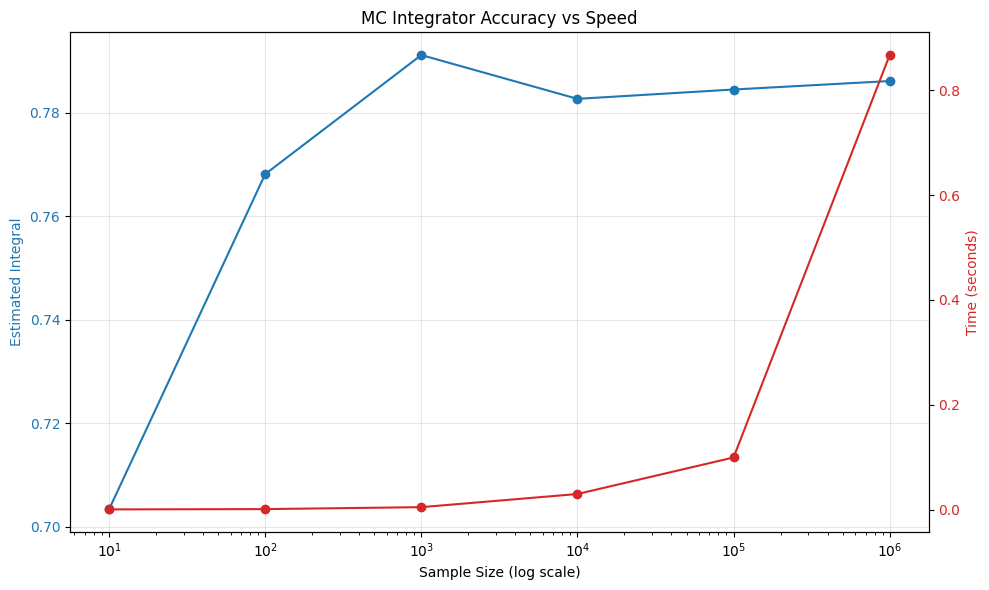

In [11]:
### TODO: Plot a graph of MC Integrator Accuracy vs Speed
import time

sample_sizes = [10, 100, 1000, 10000, 100000, 1000000]
results, times = [], []

for n in sample_sizes:
    start_time = time.time()
    integral = mc_integrator(specific_integral_function, a, b, n)
    elapsed_time = time.time() - start_time
    results.append(integral)
    times.append(elapsed_time)

fig, ax1 = plt.subplots(figsize=(10, 6))

color = "tab:blue"
ax1.set_xlabel("Sample Size (log scale)")
ax1.set_ylabel("Estimated Integral", color=color)
ax1.plot(sample_sizes, results, 'o-', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xscale('log')
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = "tab:red"
ax2.set_ylabel("Time (seconds)", color=color)  # we already handled the x-label with ax1
ax2.plot(sample_sizes, times, 'o-', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("MC Integrator Accuracy vs Speed")
fig.tight_layout()
plt.show()

## Monte Carlo Prediction

### General Overview

Monte Carlo Prediction is a technique in Reinforcement Learning (RL) used to estimate the value of states (or state-action pairs) based on the observed returns from sampled episodes. The goal is to approximate the value function, which represents the expected return (cumulative future rewards) starting from a given state under a specific policy.

- **Objective**: For a given policy $ \pi $, Monte Carlo methods aim to estimate the **value function** $ V^\pi(s) $ for each state $ s $, which is the expected return starting from $ s $, and following the policy $ \pi $. We estimate the expected return using mean returns.
- **Episode-based learning**: Monte Carlo methods compute value estimates by averaging returns across multiple episodes. An episode is a sequence of states, actions, and rewards that ends in a terminal state.
  
In Monte Carlo Prediction, the value of a state is updated based on the actual returns received in episodes, which allows it to handle non-Markov environments and environments where a model of the dynamics is unknown. This is why Monte Carlo prediction is called *'model-free'* learning algorithm. This method works particularly well for **episodic tasks** where we can easily define when an episode starts and ends.

---

The steps involved in Monte Carlo prediction are as follows:

1. First, we initialize a random value to our value function.
2. Then we initialize an emplty list called a return to store our return.
3. Then for each state in the episode, we calculate the return.
4. Next, we append the return to out return list.
5. Finally, we take average of return as our value function.

----

The Monte Carlo Prediction algorithm is of two types;

- First Visit Monte Carlo
- Every Visit Monte Carlo

### First Visit Monte Carlo

In First Visit Monte Carlo (MC) we average the return only the first time the state is visited in an episode. In Reinforcement Learning, a state may be visited multiple times within a single episode.
- First Visit Monte Carlo focuses on the first occurrence of each state to provide an unbiased estimate of its value.

- First Visit ensures that the value of a state is only updated once per episode, based on the first time it was encountered.
- This method helps avoid correlation between multiple visits to the same state in a single episode, which can introduce bias into the value estimation.
By averaging the returns for the first visits over many episodes, we get a robust estimate of the value function for each state.

#### Algorithm for First Visit MC Prediction:

1. **Initialize** the value function $ V(s) $ for all states arbitrarily (or to zeros) and a counter $ N(s) = 0 $ for each state $ s $ to track the number of first visits to $ s $.

2. **Simulate episodes**: For each episode:
    - Generate a complete episode by following the given policy $ \pi $.
    - An episode is a sequence of states, actions, and rewards:
      $$
      (S_0, A_0, R_1, S_1, A_1, R_2, \dots, S_T)
      $$
      where $ S_T $ is the terminal state, and $ T $ is the time step at which the episode ends.

3. **Track first visits**: For each state $ S_t $ visited in the episode, check if this is the first time it has been visited within the episode. If so:
    - **Compute the return** $ G_t $, which is the total discounted reward from time step $ t $ until the end of the episode:
      $$
      G_t = R_{t+1} + \gamma R_{t+2} + \dots + \gamma^{T-t} R_T
      $$
    - **Update the value function** $ V(S_t) $ based on this return:
      $$
      V(S_t) \leftarrow V(S_t) + \alpha [G_t - V(S_t)]
      $$
      where $ \alpha $ is the learning rate, or:
      $$
      α = \frac{1}{N(S_t)}
      $$
      if you are averaging over all returns for state $ S_t $.
  
    - **Update the count** for the first visit to the state:
      $$
      N(S_t) \leftarrow N(S_t) + 1
      $$

4. **Repeat** this process over many episodes to improve the estimates of the value function.

---

More concisely, the algorithm is as follows:

<img src="https://lcalem.github.io/imgs/sutton/first_visit.png" alt="Girl in a jacket" width="700" height="300">


In [6]:
### TODO: Implement a function to generate an episode using policy (pi)

def generate_episodes(env, policy=None, n_episodes=1) -> list:
    episodes = []
    
    for _ in range(n_episodes):
        episode = []
        state, _ = env.reset()
        done = False
        
        while not done:
            if policy is None: action = env.action_space.sample()  # Random policy
            else: action = policy(state)
            
            next_state, reward, terminated, truncated, _ = env.step(action)
            episode.append((state, action, reward))
            
            state = next_state
            done = terminated or truncated
        episodes.append(episode)
    
    return episodes if n_episodes > 1 else episodes[0]

In [7]:
from collections import defaultdict

def first_visit_mc_prediction(env, n_episodes, gamma=1.0, policy=None):
    # First, we initialize the empty value table as a dictionary for storing the values of each state
    value_table = defaultdict(float)
    N = defaultdict(int)

    for i in range(n_episodes):
        # TODO: Generate the epsiode and store the states and rewards
        episode = generate_episodes(env, policy=policy)

        # TODO: For each step, we store the rewards to a variable R and states to S, and we calculate
        # returns as a sum of rewards
        states = [s for s, _, _ in episode]
        rewards = [r for _, _, r in episode]
        visited_states = set()

        G = 0

        for t in range(len(states) - 1, -1, -1):
            G = gamma * G + rewards[t]
            state = states[t]

            # TODO: Perform first visit MC, we check if the episode is visited for the first time, if yes,
            # we simply take the average of returns and assign the value of the state as an average of returns

            if state not in visited_states: 
                visited_states.add(state)
                N[state] += 1
                value_table[state] += (G - value_table[state]) / N[state]
        
        if (i + 1) % 10000 == 0:
            print(f"First-visit MC: Completed {i + 1}/{n_episodes} episodes")

    return value_table

### Every Visit Monte Carlo

**Every Visit Monte Carlo** is a model-free prediction method in Reinforcement Learning (RL) used to estimate the value function $ V^\pi(s) $ of a given policy $ \pi $. Like other Monte Carlo methods, it uses complete episodes of experience and updates the estimated value of a state based on the **returns** from multiple episodes.

The key feature of **Every Visit Monte Carlo** is that it updates the value of a state every time the state is visited within an episode, rather than just the first time (which is what happens in First Visit Monte Carlo).

---

### Why Use Every Visit Monte Carlo?

In environments where states can be revisited multiple times within the same episode, **Every Visit Monte Carlo** provides a way to leverage all available information by updating the value of a state each time it is visited.

- **More frequent updates**: By updating the value of a state for every visit, you can learn faster in environments where the agent frequently revisits the same state.
- **Utilizes more data**: Every occurrence of a state gives more opportunities to estimate the value, which may lead to faster convergence of the value function compared to First Visit Monte Carlo.

---

In [8]:
### TODO: Complete 'every_visit_mc_prediction()' function

def every_visit_mc_prediction(env, n_episodes, gamma=1.0):

    # First, we initialize the empty value table as a dictionary for storing the values of each state
    value_table = defaultdict(float)
    N = defaultdict(int)


    for i in range(n_episodes):
        # TODO: Generate the epsiode and store the states and rewards
        episode = generate_episodes(env)

        states = [s for s, _, _ in episode]
        rewards = [r for _, _, r in episode]

        G = 0
        # TODO: For each step, we store the rewards to a variable R and states to S, and we calculate
        # returns as a sum of rewards
        for t in range(len(states) - 1, -1, -1):
            G = gamma * G + rewards[t]
            state = states[t]

            # TODO: Perform every visit MC, we simply take the average of returns and assign the value of the state as an average of returns
            N[state] += 1
            value_table[state] += (G - value_table[state]) / N[state]

        if (i + 1) % 10000 == 0:
            print(f"Every-visit MC: Completed {i + 1}/{n_episodes} episodes")

    return value_table


### Key Differences between First Visit Monte Carlo and Every Visit Monte Carlo:

- **Every Visit Monte Carlo** updates the value of a state every time it is visited within an episode, whereas **First Visit Monte Carlo** updates the value only the first time a state is encountered.
- **Every Visit Monte Carlo** tends to use more data for updating the value function since it uses all occurrences of each state within an episode, potentially leading to faster learning in some cases.
- **First Visit Monte Carlo** avoids correlation between multiple visits to the same state, while Every Visit Monte Carlo exploits multiple visits to gather more data but may introduce more noise or bias in certain environments.

Both methods will converge to the correct value function given enough episodes, but they may differ in how fast they converge depending on the environment and the task.

### Playing Black-Jack with Monte Carlo Methods


In [ ]:
def extract_policy(env,value_table, gamma = 1.0):
    if isinstance(env.observation_space, gym.spaces.Discrete):
        policy = np.zeros(env.observation_space.n, dtype=int)  # Use integers for actions
    else:
        policy = {}

    # Iterate through all states in the value table
    for state in value_table.keys():
        # Compute the action with the maximum expected value
        best_action = np.argmax([
            value_table.get((state, action), -1) for action in range(env.action_space.n)
        ])
        policy[state] = best_action
    
    return policy


In [27]:
env_train = gym.make('Blackjack-v1', natural=False, sab=False)
venv_train = env_train.unwrapped

In [28]:
value_first_visit_mc = first_visit_mc_prediction(venv_train, n_episodes=500000)
optimal_policy_first_visit = extract_policy(venv_train,value_first_visit_mc, gamma=0.9)
# value_first_visit_mc = first_visit_mc_prediction(env_train, n_episodes=500000)
# optimal_policy_first_visit = extract_policy(env_train,value_first_visit_mc, gamma=0.9)

First-visit MC: Completed 10000/500000 episodes
First-visit MC: Completed 20000/500000 episodes
First-visit MC: Completed 30000/500000 episodes
First-visit MC: Completed 40000/500000 episodes
First-visit MC: Completed 50000/500000 episodes
First-visit MC: Completed 60000/500000 episodes
First-visit MC: Completed 70000/500000 episodes
First-visit MC: Completed 80000/500000 episodes
First-visit MC: Completed 90000/500000 episodes
First-visit MC: Completed 100000/500000 episodes
First-visit MC: Completed 110000/500000 episodes
First-visit MC: Completed 120000/500000 episodes
First-visit MC: Completed 130000/500000 episodes
First-visit MC: Completed 140000/500000 episodes
First-visit MC: Completed 150000/500000 episodes
First-visit MC: Completed 160000/500000 episodes
First-visit MC: Completed 170000/500000 episodes
First-visit MC: Completed 180000/500000 episodes
First-visit MC: Completed 190000/500000 episodes
First-visit MC: Completed 200000/500000 episodes
First-visit MC: Completed 210

In [29]:
value_every_visit_mc = every_visit_mc_prediction(venv_train, n_episodes=500000)
optimal_policy_every_visit = extract_policy(venv_train,value_every_visit_mc, gamma=0.9)
# value_every_visit_mc = every_visit_mc_prediction(env_train, n_episodes=500000)
# optimal_policy_every_visit = extract_policy(env_train,value_every_visit_mc, gamma=0.9)

Every-visit MC: Completed 10000/500000 episodes
Every-visit MC: Completed 20000/500000 episodes
Every-visit MC: Completed 30000/500000 episodes
Every-visit MC: Completed 40000/500000 episodes
Every-visit MC: Completed 50000/500000 episodes
Every-visit MC: Completed 60000/500000 episodes
Every-visit MC: Completed 70000/500000 episodes
Every-visit MC: Completed 80000/500000 episodes
Every-visit MC: Completed 90000/500000 episodes
Every-visit MC: Completed 100000/500000 episodes
Every-visit MC: Completed 110000/500000 episodes
Every-visit MC: Completed 120000/500000 episodes
Every-visit MC: Completed 130000/500000 episodes
Every-visit MC: Completed 140000/500000 episodes
Every-visit MC: Completed 150000/500000 episodes
Every-visit MC: Completed 160000/500000 episodes
Every-visit MC: Completed 170000/500000 episodes
Every-visit MC: Completed 180000/500000 episodes
Every-visit MC: Completed 190000/500000 episodes
Every-visit MC: Completed 200000/500000 episodes
Every-visit MC: Completed 210

In [48]:
total_reward = 0

# env = gym.make('Blackjack-v1', natural=False, sab=False)
env = gym.make('Blackjack-v1', natural=False, sab=False, render_mode="rgb_array")
env = gym.wrappers.RecordVideo(
    env, 
    './video',
    episode_trigger=lambda episode_id: True,
    name_prefix="blackjack")

state, _ = env.reset()
# print(f"Effin State: {state} and underscore: {_}")
done = False
total_reward = 0

# Interaction loop
while not done:
    # Get action from the optimal policy
    action = int(optimal_policy_first_visit[state])
    
    # Step through the environment
    next_state, reward, terminated, truncated, _ = env.step(action)
    
    # Update state and total reward
    state = next_state
    total_reward += reward
    done = terminated or truncated
print(f"Episode finished with total reward: {total_reward}")

env.close()


# env = wrap_env(gym.make('Blackjack-v1', natural=False, sab=False))


# # Reset the environment
# state, _ = env.reset()

# # Start the recorder (utility for displaying output)
# env.start_video_recorder()

# next_state = state

# # Example of an interaction loop
# for _ in range(10000):


#     # Render the environment
#     env.render()


#     # Sample random action from action space
#     # action = env.action_space.sample()
#     action = int(optimal_policy_first_visit[next_state])

#     # print(type(action),next_state)

#     # Step through the environment using the action
#     next_state, reward, done, info = env.step(action)

#     # Break the loop if the episode is done
#     if done:
#         break


# # close the video recorder(utility for displaying output)
# env.close_video_recorder()

# # Close the environment
# env.close()

Episode finished with total reward: 1.0


In [41]:
# Display Output
show_video()